<a href="https://colab.research.google.com/github/MrMotohiroDoi/StateofChargeEstimation/blob/main/soc_est_ukf3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
class SigmaPoints:#https://filterpy.readthedocs.io/en/latest/_modules/filterpy/kalman/sigma_points.html
    def __init__(self,n,alpha,beta,kappa):
         self.n=n
         self.alpha=alpha
         self.beta=beta
         self.kappa=kappa
         self.weights()

    def weights(self):
         self.lambda_=self.alpha**2*(self.n+self.kappa)-self.n#n=2, alpha=.3, beta=2, kappa=1
         self.Wc=np.full(2*self.n+1, 1/(2*(self.n+self.lambda_)))#a = np.full(6, 6) b = np.full((2,3), 7.1) a =  [6 6 6 6 6 6] b =  [[ 7.1  7.1  7.1] [ 7.1  7.1  7.1]]
         self.Wm=np.full(2*self.n+1,1/(2*(self.n+self.lambda_)))
         self.Wc[0]=(self.lambda_/(self.n+self.lambda_))+(1-self.alpha**2+self.beta)#Wc=[Wc[0],1/(2*(self.n+self.lambda_)),1/(2*(self.n+self.lambda_)),,,,]
         self.Wm[0]=self.lambda_/(self.n+self.lambda_)

    def sigmas(self,X,P):#X=[I_mean,SOC_mean]
         self.sigmas=np.zeros((2*self.n+1,self.n))#[[XI_0,XSOC_0],[XI_1,XSOC_1],,[XI_4,XSOC_4]]
         U=np.linalg.cholesky((self.n+self.lambda_)*P)
         self.sigmas[0]=X#[XSOC_0]=[SOC_mean]
         for k in range(self.n):
             self.sigmas[k+1]=X+U[k]
             self.sigmas[self.n+k+1]=X-U[k]
         return self.sigmas

In [3]:
def unscented_transform(f_sigmas,Wm,Wc,Q):#f_sigmas(5,2),Wm,Wc(1,5), Actually, Q is not a parameter related to this transform, but this parameter is useful when you want to use this function for UKF.
    ut_mean=np.dot(Wm,f_sigmas)
    dy=f_sigmas-ut_mean[np.newaxis,:]#ut_mean[np.newzeis,:]=[[ut_mean(1,2)],[ut_mean(1,2)],[ut_mean(1,2)]....]
    #ut_cov=np.dot(np.diag(Wc), np.dot(dy.T,dy))+Q#https://colab.research.google.com/drive/1Y4J92OqxpzEw44BAkX7PHNjmt3xtF0IP#scrollTo=_NE30RRaRTko&line=2&uniqifier=1
    ut_cov=np.dot(dy.T, np.dot(np.diag(Wc), dy))+Q
    return (ut_mean,ut_cov)#use this like mean,cov=unscented_transform()


In [4]:

class UnscentedKalmanFilter:

    def __init__(self, points, fx, hx,dt,dim_z):
        self._num_sigmas=2*points.n+1
        self._dim_x=points.n
        self._dim_z=dim_z
        self.sigma_points_fn=points.sigmas
        self.fx=fx
        #self.sigmas_f=np.zeros((2*points.n+1,points.n))
        self.Wm=points.Wm
        self.Wc=points.Wc
        self.sigmas_h=np.zeros((2*points.n+1,dim_z))
        self.hx=hx
        self.dt=dt

    def predict(self,sns_c,fcc,res):
        sigmas=self.sigma_points_fn(self.x, self.P)#[[SOC0,v0],[SOC1,v1],,,]
        for i in range(self._num_sigmas):
            self.sigmas_f[i]=self.fx(sigmas[i],sns_c,self.dt,fcc,res)#assign sigmapoints to fx
        self.x, self.P=unscented_transform(self.sigmas_f,self.Wm,self.Wc,self.Q)#generate new sigmapoints

    def update(self,z):
        for i in range (self._num_sigmas):
            self.sigmas_h[i]=self.hx(self.sigmas_f[i])#convert sigmapoints into a measurement vector.
        zp,Pz=unscented_transform(self.sigmas_h,self.Wm,self.Wc,self.R) # compute cross variance of the state and the measurements
        Pxz=np.zeros((self._dim_x,self._dim_z))
        for i in range(self._num_sigmas):
            Pxz+=self.Wc[i]*np.outer(self.sigmas_f[i]-self.x,self.sigmas_h[i]-zp)#covariance matrix (zp is a prior in the measurement space
        K=np.dot(Pxz,np.linalg.inv(Pz))
        self.x=self.x+np.dot(K,z-zp)
        self.P=self.P-np.dot(K,Pz).dot(K.T)












In [5]:
def fx(sigmas_i,c,dt,fcc,res):#Unit of dt is s, fcc is mAh
    soc=sigmas_i[0]
    current=c
    cap=(fcc/1000)*60*60 #Unit: c
    soc_p=soc-current*dt/cap
    v_p=res*c
    return np.array([soc_p,v_p])




def focv(xdata):#xdata is soc
    x=[4.1312, -0.4637, 0.7673, -0.2874 ,0.0188, -3.3851]
    return x[0]+(x[1]*(-np.log(xdata))**x[2])+x[3]*xdata+x[4]*np.exp(x[5]*(xdata-1))

def hx(x):
    R=18e-3#ohm
    s=x[0]#s is soc
    v=x[1]
    if s<0.03:
        return focv(0.03)+((focv(0.03+1e-5)-focv(0.03-1e-5))/2e-5)*(s-0.03)-v
    elif s>0.98:
        return focv(0.98)+(focv(0.98+1e-5)-focv(0.98-1e-5))/2e-5*(s-0.98)-v
    else:
        return focv(s)-v




In [6]:
dt=0.1
fcc=14080#mAh
res=0.00175#ohm
offset=-1#current sensor offset
def soc_estimation(cs,sigma_csense,sigma_vsense,sigma_res):#cs is [c,c,c,c....],Unit:A
    points =SigmaPoints(n=2, alpha=0.003, beta=2, kappa=2)
    ukf=UnscentedKalmanFilter(points=points, fx=fx, hx=hx,dt=1,dim_z=1)
    ukf.x=np.array([0.9,cs[0]*res])#np.array([SOC,v])
    sim_state0=np.array([1,cs[0]*res])#Actually, sim_state0 may be slightly off from 1, such as 0.98.
    ukf.P=np.diag([0.01,0.01])#The initial covariance of SOC(0.1^2), v(0.1^2)
    ukf.sigmas_f=points.sigmas(ukf.x,ukf.P)#The sequence update -> predict requires this assignment.
    ukf.R=np.diag([sigma_vsense])#mesurment covariance
    #ukf.Q

    #initial true values
    sim_state=sim_state0.tolist()#initial value
    curve=[ukf.x.copy(),sim_state]


    soc_int=ukf.x.copy()[0]#SOC by current integrating method.
    soc_ints=[soc_int]

    snss=[]#Values of sensors


    for i , c in enumerate(cs):


        sns_c=c+offset+np.random.randn()*np.sqrt(sigma_csense)

        z=hx(sim_state)+np.random.randn()*np.sqrt(sigma_vsense)
        sns=[sns_c,z]#current, voltage
        ukf.update(z)

        ukf.Q=np.diag([(sigma_csense*dt)/((fcc/1000)*60*60),(dt**2)*sigma_res*sigma_csense+dt*(c**2)*sigma_res+dt*(res**2)*sigma_csense])



        ukf.predict(sns_c,fcc,res)
        sim_state=fx(sim_state,c,dt,fcc,res).tolist()



        snss.append(sns)
        soc_int=fx(np.array([soc_int,]),sns_c,dt,fcc,res)[0]
        soc_ints.append(soc_int)
        curve.append(ukf.x.tolist())
        curve.append(sim_state)
    return curve,snss,soc_ints






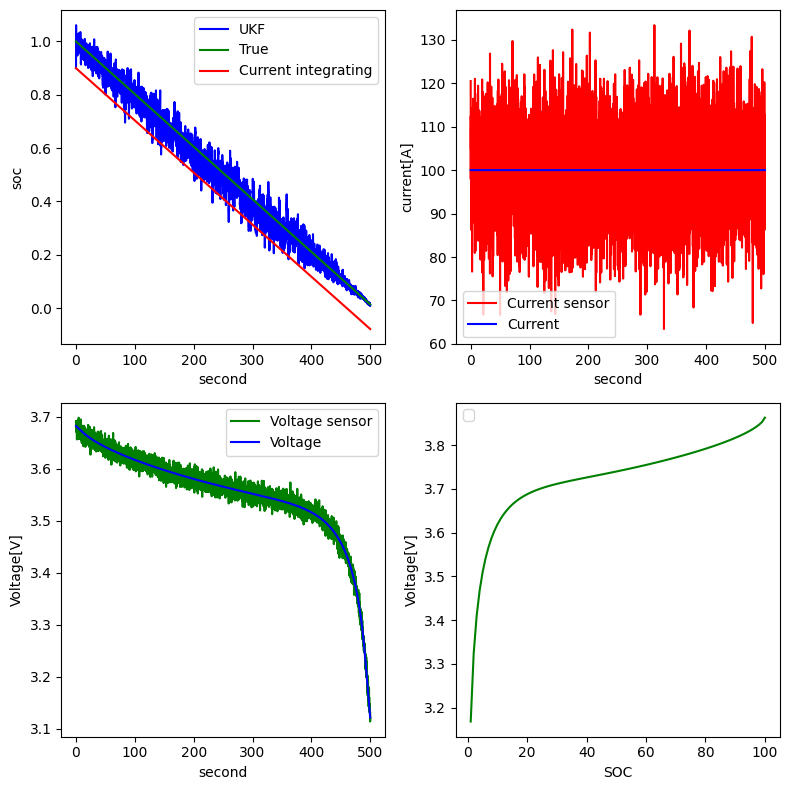

In [7]:
from matplotlib.rcsetup import validate_hist_bins
#generate current values[A] without error.
cs=[100]*5000
#cs= [math.sin(num/10)*10+10 for num in range(0,1000)]
#cs=[(num/200)**2 for num in range(1,3500)]

curve, snss, c_inte=soc_estimation(cs,sigma_csense=100,sigma_vsense=0.0001,sigma_res=(0.001**2))
soc=0
cur=1
type_=soc

t = [(n+1)*dt for n in list(range(len(cs)))]
t.insert(0,0)
t1= [n*dt for n in list(range(len(cs)))]
soc_true=[x[type_] for x in curve[1::2]]
soc_est=[x[type_] for x in curve[0::2]]
c_sns=[x[0] for x in snss]
c_true=cs
soc_true1=soc_true.copy()
del soc_true1[0]
sim_states=list(zip(soc_true1,[n*res for n in cs]))
V_true=[hx(n) for n in sim_states]
V_sns=[n[1] for n in snss]



#https://qiita.com/trami/items/bd54f22ee4449421f2bc
fig=plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2, 2, 1)
ax2=fig.add_subplot(2,2,2)
ax3=fig.add_subplot(2,2,3)
ax4=fig.add_subplot(2,2,4)




c1,c2,c3,c4,c5 = "blue","green","red" ,"red","blue"
l1,l2,l3,l4,l5,l6,l7,l8 = "UKF","True","Current integrating","Current sensor","Current","Voltage sensor","Voltage","SOC"

ax1.plot(t, soc_est,  color=c1, label=l1)
ax1.plot(t, soc_true,  color=c2, label=l2)
ax1.plot(t, c_inte,  color=c3, label=l3)
ax1.set_xlabel('second')
ax1.set_ylabel('soc')
ax1.legend(loc = 'upper right')

ax2.plot(t1, c_sns,color=c4,label=l4)
ax2.plot(t1, c_true,color=c5,label=l5)
ax2.set_xlabel('second')
ax2.set_ylabel('current[A]')
ax2.legend()

ax3.plot(t1, V_sns,color=c2,label=l6)
ax3.plot(t1, V_true,color=c1,label=l7)
ax3.set_xlabel('second')
ax3.set_ylabel('Voltage[V]')
ax3.legend()

ax4.plot([100-n for n in range(100)],[focv(1-n/100) for n in range(100)] ,color=c2,)
ax4.set_xlabel('SOC')
ax4.set_ylabel('Voltage[V]')
ax4.legend()

fig.tight_layout()              #レイアウトの設定
plt.show()


In [ ]:
soc_true[0]

1.0

In [ ]:
x=[4.1312, -0.4637, 0.7673, -0.2874 ,0.0188, -3.3851]
x[0]

4.1312